In [1]:
 import os

In [2]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('validation-horse-or-human/validation-horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('validation-horse-or-human/validation-humans')

In [12]:
import tensorflow as tf
import os 
import keras
from keras.applications import inception_v3 as inc_net
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions
from skimage.io import imread
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import random
print('Notebook run using keras:', keras.__version__)
from keras.callbacks import EarlyStopping, ModelCheckpoint 

Using TensorFlow backend.


Notebook run using keras: 2.3.1


In [4]:
print(tf.__version__)

1.15.0


In [16]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
   # The fourth convolution
    tf.keras.layers.Conv2D(8, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    #tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('horses') and 1 for the other ('humans')
    tf.keras.layers.Dense(2, activation='softmax')
])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 16)        4624      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 17, 17, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 8)        

In [18]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='mse',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        'horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=128,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

# Flow training images in batches of 128 using train_datagen generator
validation_generator = validation_datagen.flow_from_directory(
        'validation-horse-or-human/',  # This is the source directory for training images
        target_size=(150, 150),  # All images will be resized to 150x150
        batch_size=32,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    directory=r"test-horse-or-human",
    target_size=(150, 150),
    color_mode="rgb",
    batch_size=8,
    class_mode=None,
    shuffle=False
)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Found 8 images belonging to 1 classes.


In [20]:
image =next(test_generator)

In [21]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=3, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

In [22]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=8,  
      epochs=30,
      verbose=1,
      validation_data = validation_generator,
      validation_steps=8,
        callbacks=callbacks_list)

Epoch 1/30
8/8 [==============================] - 2s 249ms/step - loss: 0.2493 - acc: 0.5000

Epoch 00001: val_loss improved from inf to 0.24931, saving model to model.h5
8/8 [==============================] - 25s 3s/step - loss: 0.2903 - acc: 0.5050 - val_loss: 0.2493 - val_acc: 0.5000
Epoch 2/30
8/8 [==============================] - 2s 250ms/step - loss: 0.2398 - acc: 0.7656

Epoch 00002: val_loss improved from 0.24931 to 0.23981, saving model to model.h5
8/8 [==============================] - 23s 3s/step - loss: 0.2491 - acc: 0.5306 - val_loss: 0.2398 - val_acc: 0.7656
Epoch 3/30
8/8 [==============================] - 2s 257ms/step - loss: 0.2160 - acc: 0.7578

Epoch 00003: val_loss improved from 0.23981 to 0.21598, saving model to model.h5
8/8 [==============================] - 23s 3s/step - loss: 0.2557 - acc: 0.6162 - val_loss: 0.2160 - val_acc: 0.7578
Epoch 4/30
8/8 [==============================] - 2s 263ms/step - loss: 0.1955 - acc: 0.7656

Epoch 00004: val_loss improved fro


8.2. Loading a pretrained Imagenet model
ImageNet is a project which aims to provide a large image database for research purposes. It contains more than 14 million images which belong to more than 20,000 classes ( or synsets )

In [ ]:
image =next(test_generator)

In [ ]:
image[0]

In [55]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
test_generator.reset()
pred=model.predict_generator(test_generator,
steps=STEP_SIZE_TEST,
verbose=1)

1/1 [==============================] - 0s 325ms/step


In [56]:
predicted_class_indices=np.argmax(pred,axis=1)

In [57]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

99.9777615070343 is a horse


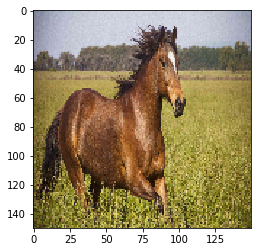

In [77]:
k= 7

f = max(pred[k])*100

f= str(f)
if pred[k][0]>0.5:
    print(f + " is a horse")
else:
    print(f + " is a human")
    
image =next(test_generator)
plt.imshow(image[k])

In [78]:
!pip install -q lime

ERROR: Error checking for conflicts.
Traceback (most recent call last):
  File "C:\Users\abhig\Anaconda3\envs\ADs\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3021, in _dep_map
    return self.__dep_map
  File "C:\Users\abhig\Anaconda3\envs\ADs\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\abhig\Anaconda3\envs\ADs\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 3012, in _parsed_pkg_info
    return self._pkg_info
  File "C:\Users\abhig\Anaconda3\envs\ADs\lib\site-packages\pip\_vendor\pkg_resources\__init__.py", line 2815, in __getattr__
    raise AttributeError(attr)
AttributeError: _pkg_info

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\abhig\An

In [79]:
%reload_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

In [80]:
explainer = lime_image.LimeImageExplainer()

In [83]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image[0],model.predict, top_labels=5, hide_color=0, num_samples=1000)


Wall time: 10 s


In [84]:
from skimage.segmentation import mark_boundaries #Using segmentation to understand better

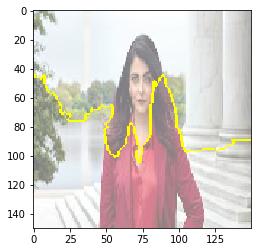

In [85]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

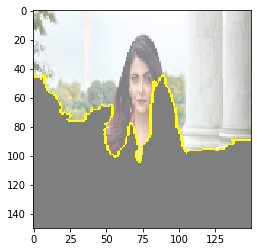

In [86]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

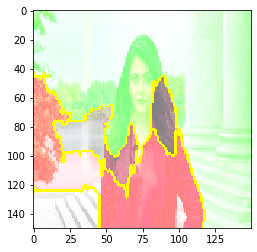

In [87]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

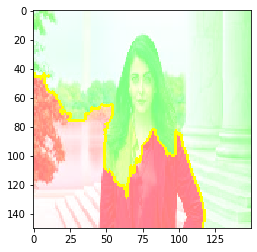

In [88]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1200, hide_rest=False, min_weight=0.001)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

In [102]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(image[6],model.predict, top_labels=5, hide_color=0, num_samples=1000)


Wall time: 9.96 s


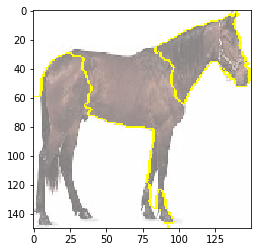

In [103]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

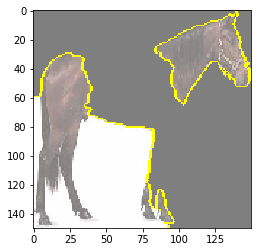

In [104]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

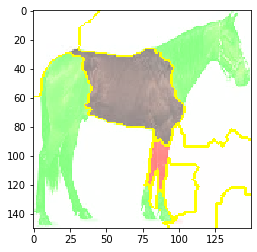

In [105]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

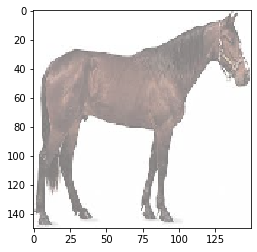

In [107]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1200, hide_rest=False, min_weight=0.001)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))